In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter
import datetime as dt

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("fivethirtyeight")

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
helper_dir = '../helper'

%run {helper_dir}/defillama.py
%run {helper_dir}/plot.py

In [3]:
obj = DefiLlama()

## Get latest yields for all pools, along with other info

In [4]:
df = obj.get_pools_yields() # See https://defillama.com/yields for the meaning of columns.
print(df.shape)
df.head() 

(9526, 24)


,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,...,sigma,count,outlier,underlyingTokens,predictedClass,predictedProbability,binnedConfidence
0,Ethereum,lido,stETH,5611444217,5.5000,NaN,5.5000,...,0.0188,150,False,None,Stable/Up,65.0000,2.0000
1,Tron,justlend,BTC,2090851253,0.0000,0.0349,0.0349,...,0.0010,85,False,[TN3W4H6rK2ce4vX9YnFQHwKENnHjoxb3m9],Stable/Up,63.0000,2.0000
2,Ethereum,curve,ETH-stETH,1660503024,3.4474,2.9908,6.4383,...,1.6145,231,True,"[0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE, 0...",Stable/Up,64.0000,2.0000
3,Ethereum,aave-v2,STETH,1071583093,0.0000,NaN,0.0000,...,0.0000,64,False,[0xae7ab96520de3a18e5e111b5eaab095312d7fe84],None,NaN,NaN
4,Ethereum,convex-finance,ETH-stETH,983141023,3.4474,3.3717,6.8191,...,0.0897,231,False,"[0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE, 0...",Stable/Up,53.0000,1.0000


In [5]:
df.columns

Index(['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy',
       'rewardTokens', 'pool', 'apyPct1D', 'apyPct7D', 'apyPct30D',
       'stablecoin', 'ilRisk', 'exposure', 'poolMeta', 'mu', 'sigma', 'count',
       'outlier', 'underlyingTokens', 'predictedClass', 'predictedProbability',
       'binnedConfidence'],
      dtype='object')

In [6]:
# let's look at TriCrypto pools on Ethereum and Arbitrum, discarding outlier pools (with extreme APYs and usually low TVL)
is_true = (df.symbol.isin(['yvCurve-Tricrypto', 'USDT-WBTC-WETH', 'WBTC-WETH-USDC']) & 
           df.chain.isin(['Ethereum', 'Arbitrum']) & 
           (~df.outlier))

# I guess columns `mu` and `sigma` are mean and standard deviation of past APYs over `count` many APYs.
# `apyPct7D` is pct change in APY for the last 7 days; `apyPct30D` is NaN for all records.
# `predictedClass` is DeFiLlama's prediction on which way the APY is heading to. 
cols = ['chain', 'project', 'symbol', 'tvlUsd', 'apyBase', 'apyReward', 'apy', 'apyPct7D', 
        'mu', 'sigma', 'count', 'predictedClass', 'predictedProbability']
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
4808,Arbitrum,yearn-finance,yvCurve-Tricrypto,134134,NaN,NaN,14.6385,0.0000,8.7511,0.2195,205,Down,64.0000
42,Ethereum,convex-finance,USDT-WBTC-WETH,164791216,1.7220,12.1039,13.8260,-0.8365,14.4672,0.4504,174,Stable/Up,63.0000
634,Arbitrum,balancer,WBTC-WETH-USDC,6001646,2.9636,7.5289,10.4926,-1.1510,16.2790,0.2997,230,Stable/Up,74.0000
4771,Arbitrum,pickle,USDT-WBTC-WETH,136626,NaN,NaN,9.8080,-0.7468,10.2124,0.1795,143,Stable/Up,58.0000
39,Ethereum,curve,USDT-WBTC-WETH,173853958,1.6029,6.2781,7.8811,-0.7281,8.7461,0.2017,231,Stable/Up,61.0000
325,Arbitrum,curve,USDT-WBTC-WETH,15667867,1.9194,0.0000,1.9194,-0.6697,1.3288,0.0493,187,Down,71.0000
2996,Ethereum,curve,USDT-WBTC-WETH,369988,1.5088,0.0000,1.5088,0.7181,0.7559,0.0480,187,Down,71.0000


In [7]:
# let's find multi-sided stablecoin pools without IL and with TVL > $1M on Arbitrum
is_true = (df.chain == 'Arbitrum') & df.stablecoin & (df.ilRisk == 'no') & (df.exposure == 'multi') & (df.tvlUsd > 1e6) & (~df.outlier)
df.loc[is_true, cols].sort_values('apy', ascending=False)

,chain,project,symbol,tvlUsd,apyBase,apyReward,apy,apyPct7D,mu,sigma,count,predictedClass,predictedProbability
818,Arbitrum,uniswap,DAI-USDC,4015665,14.2502,NaN,14.2502,9.6085,0.6965,0.1357,185,Down,90.0000
1127,Arbitrum,uniswap,USDT-USDC,2425636,3.3837,NaN,3.3837,-1.6340,0.5528,0.0981,185,Down,64.0000
1268,Arbitrum,curve,FRAX-USDC,1968685,0.9909,0.0000,0.9909,-0.1455,1.2284,0.0671,62,Stable/Up,69.0000
931,Arbitrum,uniswap,USDs-USDC,3298002,0.3092,NaN,0.3092,-0.1525,0.0703,0.0151,185,Down,64.0000
200,Arbitrum,curve,USDC-USDT,27771639,0.1171,0.0000,0.1171,-0.0886,0.1536,0.0113,187,Down,54.0000
443,Arbitrum,curve,VST-FRAX,10421036,0.1056,0.0000,0.1056,-0.0713,0.2031,0.0112,72,Stable/Up,75.0000
1295,Arbitrum,uniswap,TUSD-USDC,1903406,0.0000,NaN,0.0000,-0.0003,0.0001,0.0000,70,None,NaN
1336,Arbitrum,uniswap,USDD-USDC,1804867,0.0000,NaN,0.0000,-0.0012,0.0000,0.0000,70,None,NaN


## Get historical APY and TVL of a pool

In [8]:
# get pool ids
dat = obj.get_pools_yields()
pool_ids = dat.pool
pool_ids

0       747c1d2a-c668-4682-b9f9-296708a3dd90
1       71418c17-d2aa-4eff-b68a-806fff9ec951
2       57d30b9c-fc66-4ac2-b666-69ad5f410cce
3       0e458a5b-fd99-4667-8706-dd938934cb0c
4       5ce23e7e-3800-4c9c-ad30-6db3db0515a1
                        ...                 
9521    1a675ffc-d5a3-4e65-8d2d-4c641ae6d11d
9522    73b0e9e9-c358-48b1-a382-0ec051b27695
9523    8e91c2b5-1a00-4579-ac06-7036fe83cefa
9524    7974764c-d801-4286-9b67-1323d6bf5df1
9525    9b75270f-8d30-4e4d-88c8-245b6a84c167
Name: pool, Length: 9526, dtype: object

In [15]:
pool_id = pool_ids[10]
meta = dat.loc[dat.pool == pool_id, ['chain', 'project', 'symbol']]
meta

,chain,project,symbol
10,Ethereum,arrakis-finance,DAI-USDC


In [16]:
df = obj.get_pool_hist_apy(pool_id)
df.head()

,tvlUsd,apy,apyBase,apyReward
date,,,,
2022-07-09,"703,779,994.0000",1.2487,NaN,NaN
2022-07-10,"658,967,196.0000",1.2461,NaN,NaN
2022-07-11,"659,059,815.0000",1.2391,NaN,NaN
2022-07-12,"659,319,107.0000",1.2361,NaN,NaN
2022-07-13,"645,012,455.0000",1.2312,NaN,NaN


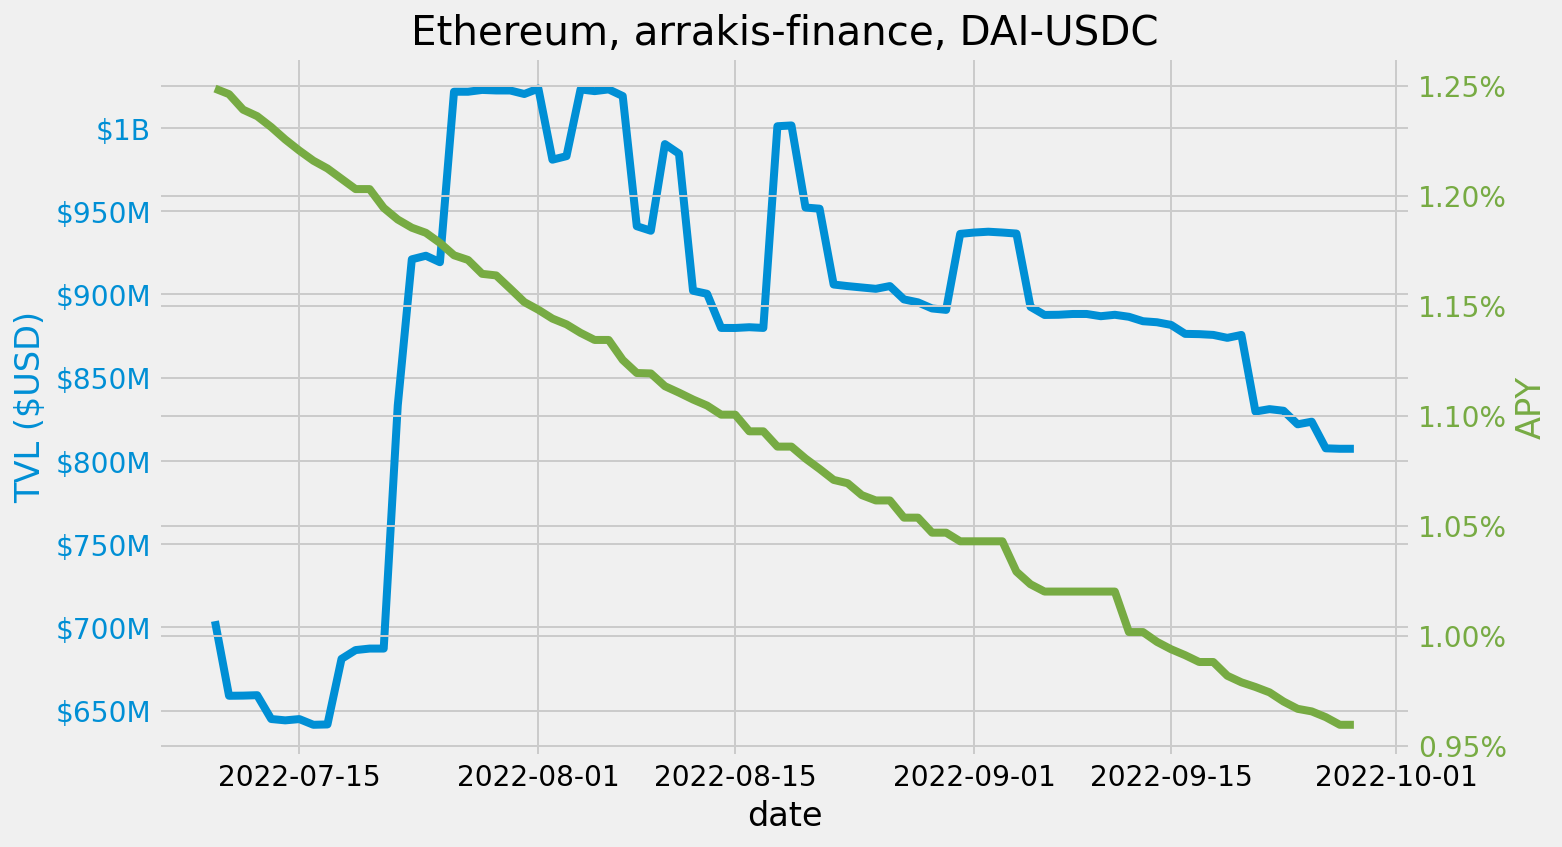

In [19]:
# plot both TVL and APY over time to see their relationships. 
fig_tit = ', '.join(meta.values.tolist()[0])

ax1 = df.tvlUsd.plot()
dollar_formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax1.yaxis.set_major_formatter(dollar_formatter)
for tl in ax1.get_yticklabels():
    tl.set_color('#008FD5')
ax1.set_ylabel('TVL ($USD)', color='#008FD5')

ax2 = ax1.twinx()
ax2.plot(df.index, df.apy, color='#77AB43')
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=2))
for tl in ax2.get_yticklabels():
    tl.set_color('#77AB43')
ax2.set_ylabel('APY', color='#77AB43')

plt.title(fig_tit);    

Remark: Yield falls as TVL decreases.